# Reinforcement Learning

This tutorial will walk through some initial concepts and algorithms for reinforcement learning (RL). I'll assume you've already done the general introduction on supervised learning with Tensorflow. We'll start with basic Q-learning to introduce the concept of RL, but you will need to be familiar with Tensorflow models for some of the later algorithms.

Additionally, the focus of this tutorial will be on RL in control applications. We'll start by introducing the cartpole problem.

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import time

from IPython import display

%matplotlib inline

In [14]:
env = gym.make("CartPole-v1")

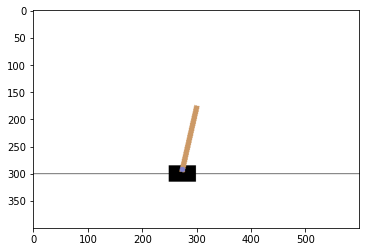

In [18]:
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    frame = env.render(mode='rgb_array')
    plt.imshow(frame)
    display.display(plt.gcf())    
    display.clear_output(wait=True)
#     time.sleep(1/30)
env.close()